# Introduction

Kaggle Money Painting

Competition Description:

A GAN consists of at least two neural networks: a generator model and a discriminator model. The generator is a neural network that creates the images. For our competition, you should generate images in the style of Monet. This generator is trained using a discriminator.

The two models will work against each other, with the generator trying to trick the discriminator, and the discriminator trying to accurately classify the real vs. generated images.

Your task is to build a GAN that generates 7,000 to 10,000 Monet-style images.

## Problem Statement

The Kaggle competition "I'm Something of a Painter Myself!" challenges participants to develop a Generative Adversarial Network (GAN) to create 7,000–10,000 images in the style of Claude Monet's paintings. The goal is to train a generator to either transform provided photos or generate new images that mimic Monet’s artistic style, while a discriminator distinguishes real Monet paintings from generated ones. Submissions are evaluated using MiFID (Memorization-informed Fréchet Inception Distance), where lower scores indicate higher-quality images with minimal memorization of the training data.

## Data Description

The dataset includes four directories: monet_jpg and monet_tfrec, each containing 300 Monet paintings (256x256), and photo_jpg and photo_tfrec, each containing 7,028 photos (256x256). The Monet images are used to train the GAN to capture the artist’s style, while the photos serve as inputs for style transfer or as a reference for generating new images. Both JPEG and TFRecord formats are provided, with TFRecords recommended for learning purposes, and submissions must consist of 7,000–10,000 Monet-style images in a zipped file.

# Inputs

In [ ]:
#import pandas as pd

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import glob
import os


from skimage.feature import graycomatrix, graycoprops, canny
from skimage.transform import resize
from sklearn.cluster import KMeans

from tensorflow.keras.applications import VGG16
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

from PIL import Image




In [9]:
monet_path = './gan-getting-started/monet_tfrec/'
photo_path = './gan-getting-started/photo_tfrec/'

# Function to parse TFRecord files
def parse_tfrecord(example):
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, feature_description)
    image = tf.io.decode_jpeg(example['image'], channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0, 1]
    return image

# Load TFRecord datasets
monet_files = glob.glob(os.path.join(monet_path, '*.tfrec'))
photo_files = glob.glob(os.path.join(photo_path, '*.tfrec'))

monet_dataset = tf.data.TFRecordDataset(monet_files).map(parse_tfrecord)
photo_dataset = tf.data.TFRecordDataset(photo_files).map(parse_tfrecord)

# EDA

## Color Distribution Analysis

### RGB Pixel Density

In [10]:
def compute_channel_means(dataset, num_images):
    red_sum = 0.0
    green_sum = 0.0
    blue_sum = 0.0
    total_pixels = 0
    
    for image in dataset.take(num_images):
        red = image[:, :, 0].numpy().flatten()
        green = image[:, :, 1].numpy().flatten()
        blue = image[:, :, 2].numpy().flatten()
        red_sum += np.sum(red)
        green_sum += np.sum(green)
        blue_sum += np.sum(blue)
        total_pixels += red.size  # Same for all channels (image height * width)
    
    mean_red = red_sum / total_pixels
    mean_green = green_sum / total_pixels
    mean_blue = blue_sum / total_pixels
    
    return mean_red, mean_green, mean_blue

# Compute and print mean intensities
monet_red_mean, monet_green_mean, monet_blue_mean = compute_channel_means(monet_dataset, num_images=300)
photo_red_mean, photo_green_mean, photo_blue_mean = compute_channel_means(photo_dataset, num_images=1000)

print("Monet Color Statistics:")
print(f"Red Mean Intensity: {monet_red_mean:.4f}")
print(f"Green Mean Intensity: {monet_green_mean:.4f}")
print(f"Blue Mean Intensity: {monet_blue_mean:.4f}")

print("\nPhoto Color Statistics:")
print(f"Red Mean Intensity: {photo_red_mean:.4f}")
print(f"Green Mean Intensity: {photo_green_mean:.4f}")
print(f"Blue Mean Intensity: {photo_blue_mean:.4f}")

2025-06-23 18:08:04.604427: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Monet Color Statistics:
Red Mean Intensity: 0.5215
Green Mean Intensity: 0.5243
Blue Mean Intensity: 0.4767

Photo Color Statistics:
Red Mean Intensity: 0.3990
Green Mean Intensity: 0.4043
Blue Mean Intensity: 0.3773


2025-06-23 18:08:06.330455: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Monet:
- Means are relatively balanced, with a slight emphasis on green and red (around 0.52) and a slightly lower blue (0.4767). 
- This aligns with Monet’s impressionistic style, often featuring landscapes with greenery and warm tones

Photo:
- means are lower overall (around 0.38–0.40), suggesting the photo dataset is darker or has a broader range of lighting conditions. 
- This difference indicates that the GAN will need to brighten and adjust the color balance to match Monet’s style.

In [11]:
def compute_histogram(dataset, num_images, bins=256, image_size=256*256):
    red_counts = np.zeros(bins)
    green_counts = np.zeros(bins)
    blue_counts = np.zeros(bins)
    count = 0
    
    for image in dataset.take(num_images):
        red = image[:, :, 0].numpy().flatten()
        green = image[:, :, 1].numpy().flatten()
        blue = image[:, :, 2].numpy().flatten()
        red_counts += np.histogram(red, bins=bins, range=(0, 1))[0]
        green_counts += np.histogram(green, bins=bins, range=(0, 1))[0]
        blue_counts += np.histogram(blue, bins=bins, range=(0, 1))[0]
        count += 1
    
    # Normalize to density
    total_pixels = count * image_size
    red_hist = red_counts / total_pixels
    green_hist = green_counts / total_pixels
    blue_hist = blue_counts / total_pixels
    return red_hist, green_hist, blue_hist

2025-06-23 18:08:07.587038: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-06-23 18:08:11.530507: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


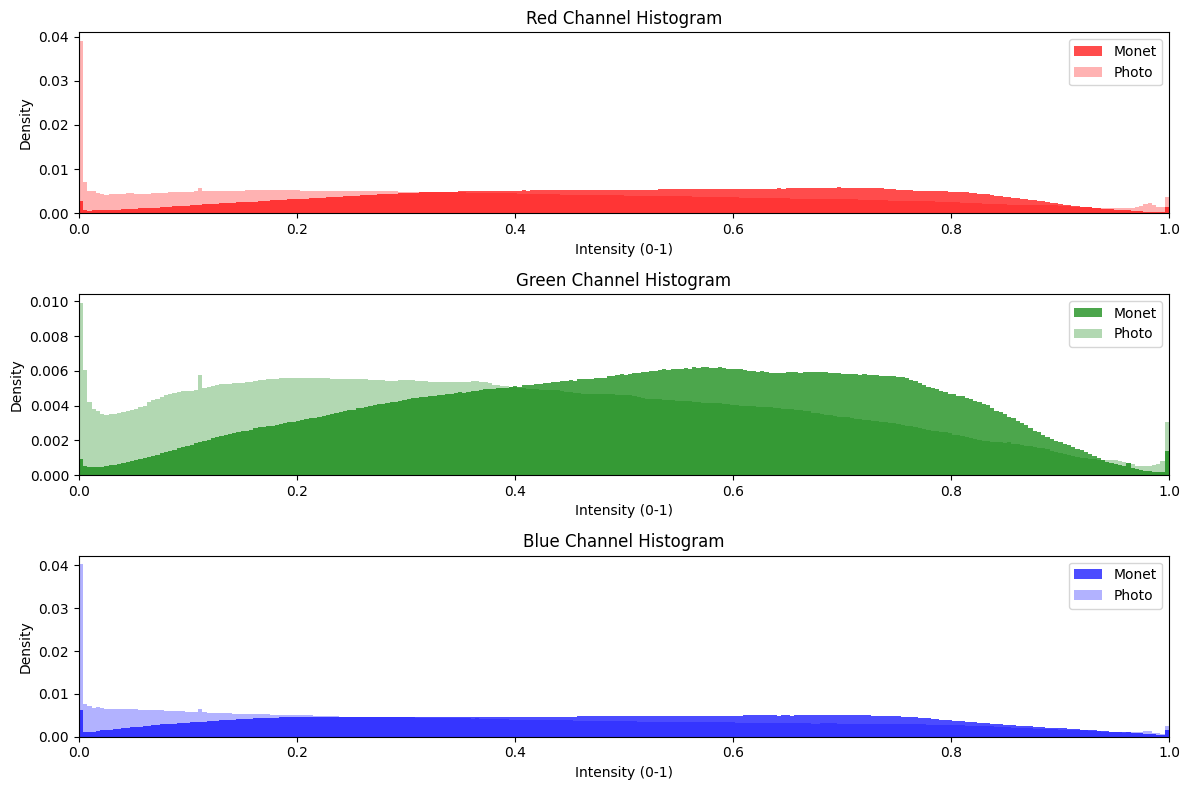

In [12]:
# Compute histograms
monet_red, monet_green, monet_blue = compute_histogram(monet_dataset, num_images=300)
photo_red, photo_green, photo_blue = compute_histogram(photo_dataset, num_images=1000)

bin_edges = np.linspace(0, 1, 257)  # 257 edges for 256 bins
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # 256 midpoints

plt.figure(figsize=(12, 8))
for i, (color, monet_hist, photo_hist, title) in enumerate([
    ('red', monet_red, photo_red, 'Red Channel Histogram'),
    ('green', monet_green, photo_green, 'Green Channel Histogram'),
    ('blue', monet_blue, photo_blue, 'Blue Channel Histogram')
]):
    plt.subplot(3, 1, i+1)
    plt.bar(bin_centers, monet_hist, width=1.0/256, color=color, alpha=0.7, label='Monet')
    plt.bar(bin_centers, photo_hist, width=1.0/256, color=color, alpha=0.3, label='Photo')
    plt.title(title)
    plt.xlabel('Intensity (0-1)')
    plt.ylabel('Density')
    plt.xlim(0, 1)
    plt.legend()
plt.tight_layout()
#plt.savefig('color_histogram_comparison.png')

There appears to be a very significant number of pixels that are black (value of 0) across all channels. This peak in black could be due to dark shadows or backgrounds within the photo, or a simple border that needs cropping. Due to both Monet and Photos having peaks at 0, it seems less likely that this is a stylistic choice of Monet, and instead may be related to the preprocessing of the image.

### Visualize Image Samples

In [13]:
def visualize_images(dataset, num_images, title):
    plt.figure(figsize=(15, 5 * num_images))
    for i, image in enumerate(dataset.take(num_images)):
        plt.subplot(num_images, 1, i+1)
        plt.imshow(image.numpy())
        plt.title(f'{title} Image {i+1}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

2025-06-23 18:08:15.403424: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


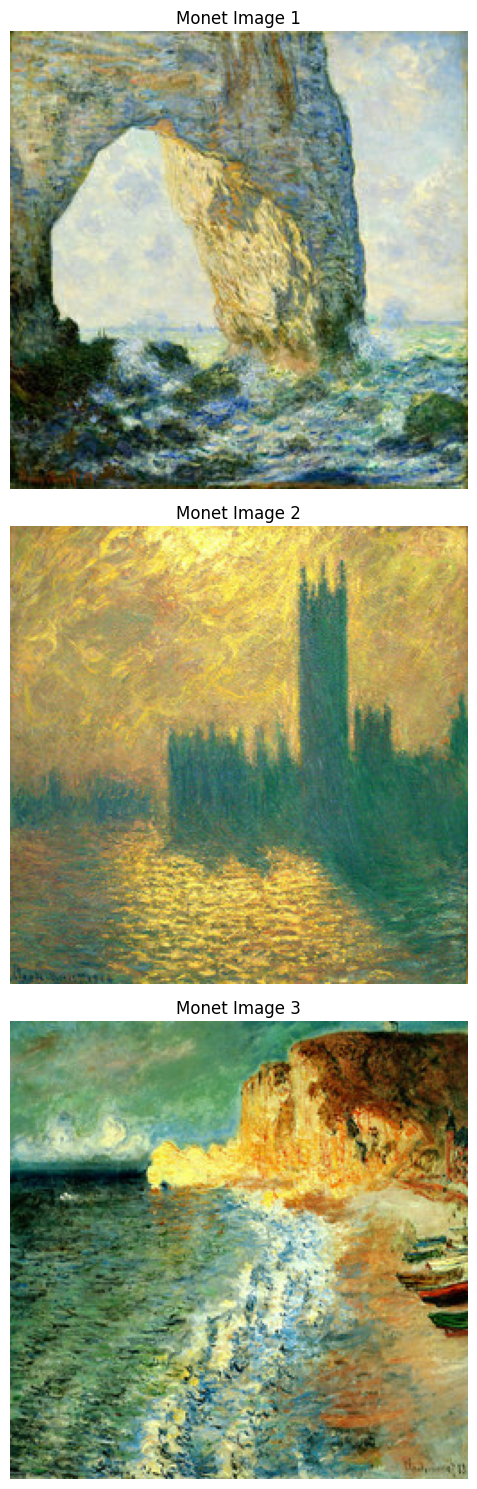

In [14]:
visualize_images(monet_dataset, num_images=3, title="Monet")

2025-06-23 18:08:16.506743: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


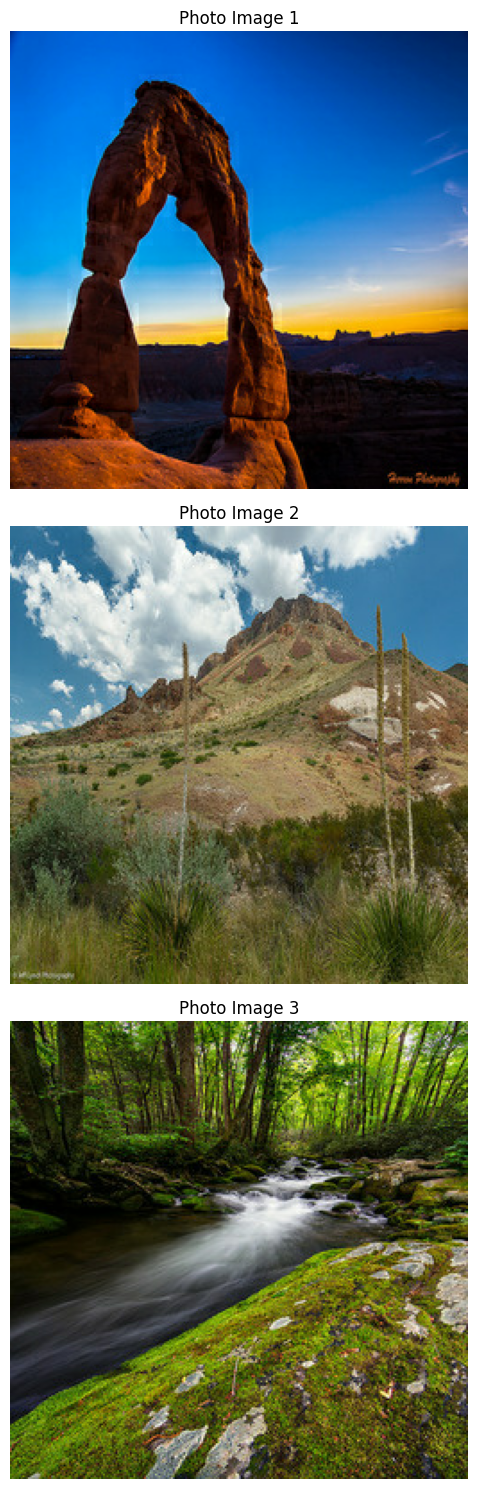

In [15]:
visualize_images(photo_dataset, num_images=3, title="Photo")

It appears that the peak in black pixels are not from the preprocessing of images, but instead are stylistic choices within the photos. The GAN will need to learn to replicate the dark areas, while still matching Monet's style.

## Texture Patterns

### Gray-Level Co-Occurrence Matrix (GLCM) Analysis

In [16]:
def compute_texture_features(dataset, num_images, distances=[1], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4], levels=256):
    contrast = []
    correlation = []
    homogeneity = []
    
    for image in dataset.take(num_images):
        # Convert to grayscale (average RGB channels)
        gray_image = tf.reduce_mean(image, axis=-1).numpy()
        # Quantize to integer levels (0-255) for GLCM
        gray_image = (gray_image * (levels - 1)).astype(np.uint8)
        
        # Compute GLCM
        glcm = graycomatrix(gray_image, distances=distances, angles=angles, levels=levels,
                           symmetric=True, normed=True)
        
        # Extract texture properties
        contrast.append(graycoprops(glcm, 'contrast').mean())
        correlation.append(graycoprops(glcm, 'correlation').mean())
        homogeneity.append(graycoprops(glcm, 'homogeneity').mean())
    
    return np.mean(contrast), np.mean(correlation), np.mean(homogeneity)

# Compute texture features
monet_contrast, monet_correlation, monet_homogeneity = compute_texture_features(monet_dataset, num_images=300)
photo_contrast, photo_correlation, photo_homogeneity = compute_texture_features(photo_dataset, num_images=1000)

print("Monet Texture Features - Contrast: {:.4f}, Correlation: {:.4f}, Homogeneity: {:.4f}".format(
    monet_contrast, monet_correlation, monet_homogeneity))
print("Photo Texture Features - Contrast: {:.4f}, Correlation: {:.4f}, Homogeneity: {:.4f}".format(
    photo_contrast, photo_correlation, photo_homogeneity))

2025-06-23 18:08:25.044833: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Monet Texture Features - Contrast: 405.7989, Correlation: 0.8969, Homogeneity: 0.1378
Photo Texture Features - Contrast: 460.4791, Correlation: 0.9066, Homogeneity: 0.2387


2025-06-23 18:08:45.832493: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


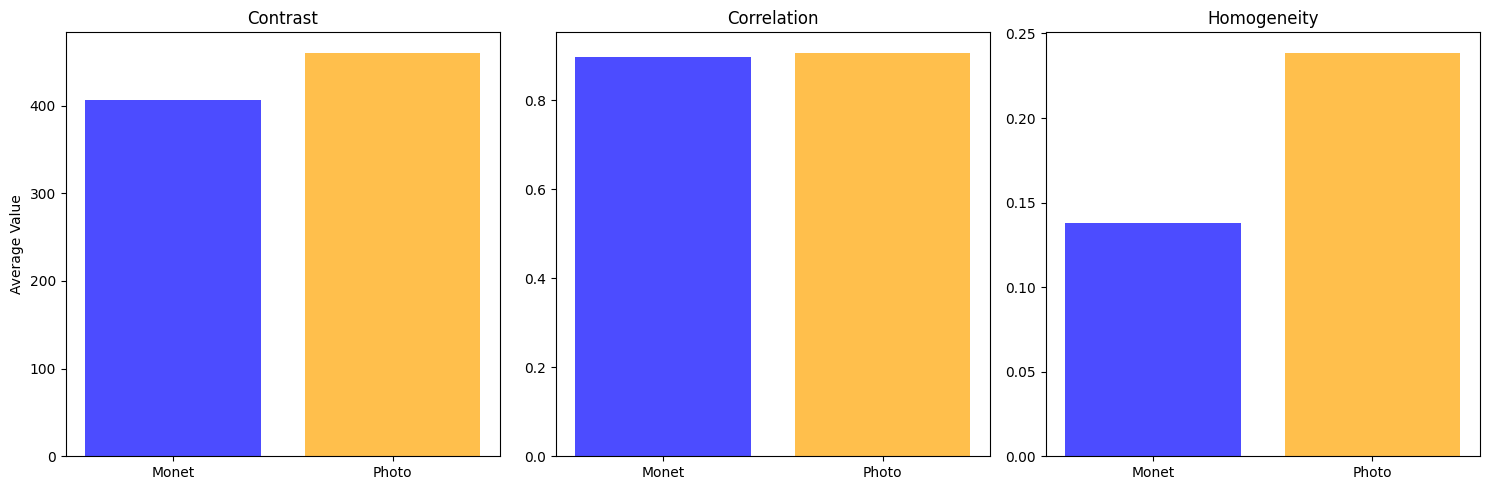

In [17]:
# Visualize texture features in separate plots
features = ['Contrast', 'Correlation', 'Homogeneity']
monet_values = [monet_contrast, monet_correlation, monet_homogeneity]
photo_values = [photo_contrast, photo_correlation, photo_homogeneity]

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.bar(['Monet', 'Photo'], [monet_values[0], photo_values[0]], color=['blue', 'orange'], alpha=0.7)
plt.title('Contrast')
plt.ylabel('Average Value')

plt.subplot(1, 3, 2)
plt.bar(['Monet', 'Photo'], [monet_values[1], photo_values[1]], color=['blue', 'orange'], alpha=0.7)
plt.title('Correlation')

plt.subplot(1, 3, 3)
plt.bar(['Monet', 'Photo'], [monet_values[2], photo_values[2]], color=['blue', 'orange'], alpha=0.7)
plt.title('Homogeneity')

plt.tight_layout()

Contrast measures the intensity variation between neighboring pixels, with higher values indicating rougher or more varied textures. Surprisingly, Photos have a higher contrast (460.4791) than Monet (405.7989), which contradicts the expectation that Monet’s brushstrokes would create more texture variation. This could be due to:
- Photo Details: The Photo dataset might include high-contrast edges (e.g., sharp objects, lighting variations) that increase contrast.
- Monet Smoothness: Monet’s impressionist style might blend colors more smoothly within brushstrokes, reducing local contrast compared to the detailed photo content.
- Implication: The GAN might need to smooth out some of the high-contrast edges in Photos to align with Monet’s style, rather than emphasizing contrast.

Correlation indicates the linear dependency of gray levels between pixels, with values closer to 1 suggesting more structured or predictable textures. Both datasets show high correlation (0.8969 for Monet, 0.9066 for Photo), but Photos are slightly higher. This suggests:
- Photo Structure: Photos might have more consistent patterns (e.g., natural gradients or object edges).
- Monet Variation: Monet’s brushstrokes introduce slight randomness, lowering correlation slightly.
- Implication: The GAN should introduce controlled randomness to reduce correlation toward Monet’s level, mimicking the less structured brushwork.

Homogeneity measures the uniformity of the texture, with higher values indicating more consistent intensity distributions. The significant difference here (0.1378 for Monet vs. 0.2387 for Photo) aligns with expectations:
- Monet Roughness: Lower homogeneity reflects the varied, non-uniform texture of brushstrokes.
- Photo Smoothness: Higher homogeneity suggests more uniform textures, typical of photographic details.
- Implication: This is a key feature to target in the GAN: reduce homogeneity in Photos to match Monet’s lower, more varied texture.

## Image Composition Clustering

In [18]:
def extract_edge_features(dataset, num_images, target_size=(64, 64)):
    edge_features = []
    for image in dataset.take(num_images):
        # Convert to grayscale
        gray_image = tf.reduce_mean(image, axis=-1).numpy()
        # Resize for efficiency
        gray_image = resize(gray_image, target_size, mode='constant', anti_aliasing=True)
        # Apply Canny edge detection
        edges = canny(gray_image, sigma=2.0)
        # Flatten edge map into a feature vector
        edge_features.append(edges.flatten())
    return np.array(edge_features)

# Perform clustering
def cluster_images(edge_features, n_clusters=3):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(edge_features)
    return clusters, kmeans.cluster_centers_


2025-06-23 18:08:46.928795: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-06-23 18:08:47.264429: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Monet Cluster Distribution: [40 59  1]
Photo Cluster Distribution: [ 1 98  1]


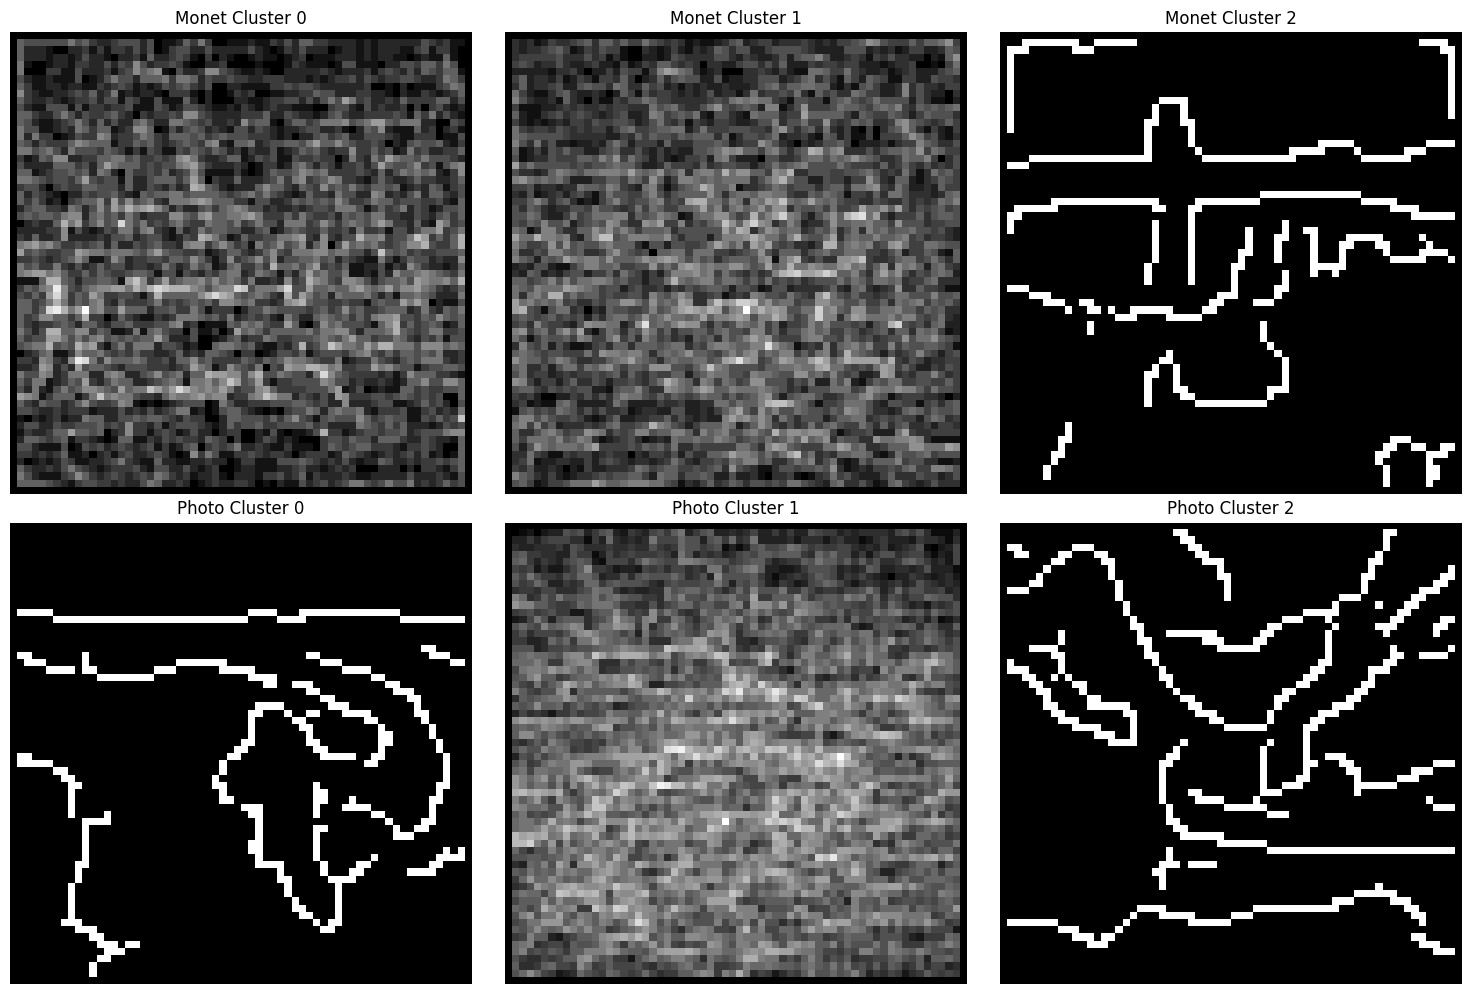

In [19]:
num_images = 100
monet_edge_features = extract_edge_features(monet_dataset, num_images)
photo_edge_features = extract_edge_features(photo_dataset, num_images)

monet_clusters, monet_centers = cluster_images(monet_edge_features, n_clusters=3)
photo_clusters, photo_centers = cluster_images(photo_edge_features, n_clusters=3)

# Print cluster distribution
print("Monet Cluster Distribution:", np.bincount(monet_clusters, minlength=3))
print("Photo Cluster Distribution:", np.bincount(photo_clusters, minlength=3))

# Visualize cluster centers (reshaped back to 2D)
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
for i in range(3):
    axs[0, i].imshow(monet_centers[i].reshape(64, 64), cmap='gray')
    axs[0, i].set_title(f'Monet Cluster {i}')
    axs[0, i].axis('off')
    axs[1, i].imshow(photo_centers[i].reshape(64, 64), cmap='gray')
    axs[1, i].set_title(f'Photo Cluster {i}')
    axs[1, i].axis('off')
plt.tight_layout()

## Feature Space Similarity

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 525ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
1/1 ━━━━━━━━━

2025-06-23 18:09:14.080757: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

2025-06-23 18:09:37.259146: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


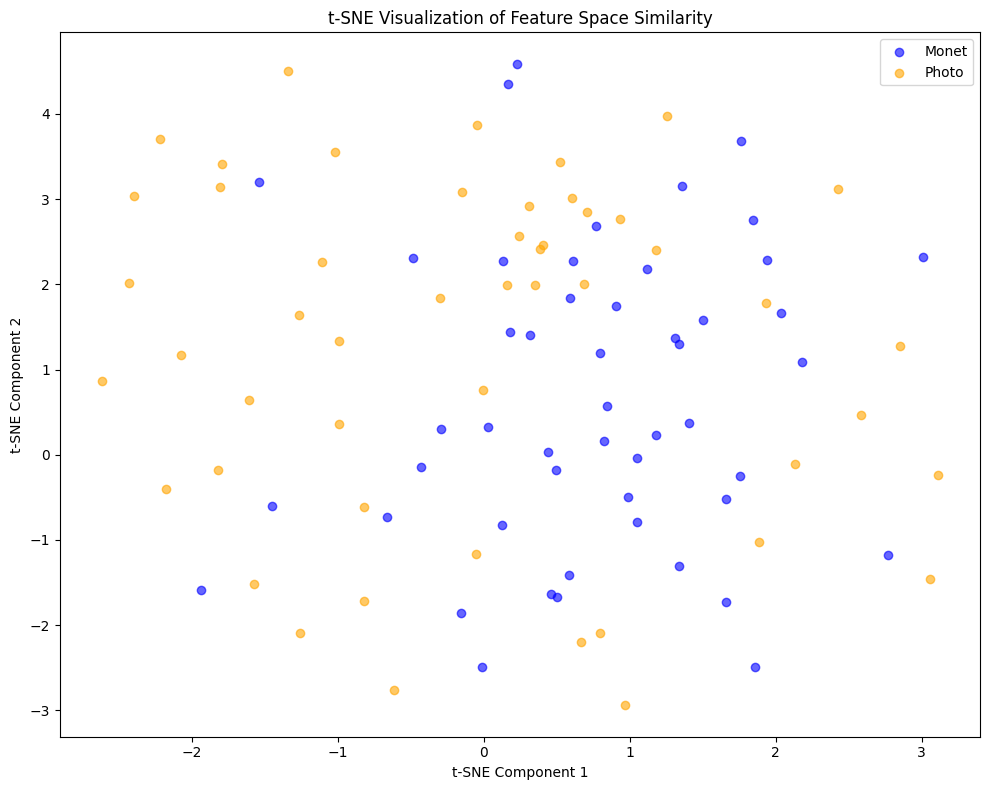

Average Monet Self-Similarity: 0.9752
Average Photo Self-Similarity: 0.9666
Average Monet-Photo Cross-Similarity: 0.9685


In [20]:
# Load pre-trained VGG16 model
vgg16 = VGG16(weights='imagenet', include_top=False, pooling='avg')
vgg16.trainable = False

# Function to extract features
def extract_features(dataset, num_images):
    features = []
    for image in dataset.take(num_images):
        image = tf.expand_dims(image, 0)  # Add batch dimension
        feature = vgg16.predict(image)
        features.append(feature.flatten())
    return np.array(features)

# Extract features
num_images = 50
monet_features = extract_features(monet_dataset, num_images)
photo_features = extract_features(photo_dataset, num_images)

# Combine and standardize features
all_features = np.concatenate([monet_features, photo_features])
scaler = StandardScaler()
all_features_scaled = scaler.fit_transform(all_features)

# Apply t-SNE for visualization
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embeddings = tsne.fit_transform(all_features_scaled)

# Separate embeddings for labeling
monet_embeddings = embeddings[:num_images]
photo_embeddings = embeddings[num_images:]

# Visualize
plt.figure(figsize=(10, 8))
plt.scatter(monet_embeddings[:, 0], monet_embeddings[:, 1], c='blue', label='Monet', alpha=0.6)
plt.scatter(photo_embeddings[:, 0], photo_embeddings[:, 1], c='orange', label='Photo', alpha=0.6)
plt.title('t-SNE Visualization of Feature Space Similarity')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.tight_layout()
plt.savefig('feature_space_similarity_tsne.png')
plt.show()

# Optional: Compute average cosine similarity within and between datasets
from sklearn.metrics.pairwise import cosine_similarity
monet_sim = cosine_similarity(monet_features)
photo_sim = cosine_similarity(photo_features)
cross_sim = cosine_similarity(monet_features, photo_features)

print(f"Average Monet Self-Similarity: {np.mean(monet_sim):.4f}")
print(f"Average Photo Self-Similarity: {np.mean(photo_sim):.4f}")
print(f"Average Monet-Photo Cross-Similarity: {np.mean(cross_sim):.4f}")

# Model Architecture
- Cycle GAN

CycleGAN is particularly well-suited for unpaired image-to-image translation tasks, which is exactly what we have here (we don't have direct "photo A" to "Monet A" pairs). It uses a "cycle consistency loss" to ensure that translating an image from domain A to domain B and back to domain A results in the original image,

In [ ]:
# --- Configuration and Path Definitions ---
# Using your specified local paths
MONET_TFREC_PATH = './gan-getting-started/monet_tfrec/'
PHOTO_TFREC_PATH = './gan-getting-started/photo_tfrec/'

# Get all TFRecord file paths
MONET_FILENAMES = tf.io.gfile.glob(os.path.join(MONET_TFREC_PATH, '*.tfrec'))
PHOTO_FILENAMES = tf.io.gfile.glob(os.path.join(PHOTO_TFREC_PATH, '*.tfrec'))

print(f'Found {len(MONET_FILENAMES)} Monet TFRecord Files.')
print(f'Found {len(PHOTO_FILENAMES)} Photo TFRecord Files.')

# Image dimensions
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
IMAGE_CHANNELS = 3
IMAGE_SIZE = [IMAGE_HEIGHT, IMAGE_WIDTH]

# AUTOTUNE for efficient data processing
AUTOTUNE = tf.data.AUTOTUNE

# --- Data Loading and Preprocessing Functions ---

def decode_image(image_data):
    """
    Decodes a JPEG image, resizes it, and normalizes pixel values to [-1, 1].
    """
    image = tf.image.decode_jpeg(image_data, channels=IMAGE_CHANNELS)
    # Normalize images to [-1, 1] range, typical for GANs with tanh activation
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, IMAGE_CHANNELS])
    return image

def read_tfrecord_example(tfrecord_proto):
    """
    Parses a single TFRecord example according to the defined format.
    Assumes TFRecords contain 'image_name', 'image', and 'target' fields.
    """
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(tfrecord_proto, tfrecord_format)
    image = decode_image(example['image'])
    return image

def load_tfrecord_dataset(filenames, max_samples=None):
    """
    Loads a dataset from TFRecord files, applying the parsing function.
    Optionally limits the number of samples for faster testing.
    """
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord_example, num_parallel_calls=AUTOTUNE)
    if max_samples is not None:
        dataset = dataset.take(max_samples) # Limit the number of samples
    return dataset

# Load datasets and batch them
# Batch size of 1 is common for CycleGAN
# Drastically reducing the number of samples for faster training demonstration
NUM_MONET_SAMPLES_FOR_QUICK_RUN = 10  # Reduced from 300
NUM_PHOTO_SAMPLES_FOR_QUICK_RUN = 50  # Reduced from 7028

monet_dataset = load_tfrecord_dataset(MONET_FILENAMES, max_samples=NUM_MONET_SAMPLES_FOR_QUICK_RUN).batch(1)
photo_dataset = load_tfrecord_dataset(PHOTO_FILENAMES, max_samples=NUM_PHOTO_SAMPLES_FOR_QUICK_RUN).batch(1)

print(f"Training on a subsample: {NUM_MONET_SAMPLES_FOR_QUICK_RUN} Monet images and {NUM_PHOTO_SAMPLES_FOR_QUICK_RUN} Photo images per epoch.")


# --- Custom InstanceNormalization Layer ---
# This replaces tfa.layers.InstanceNormalization
class InstanceNormalization(layers.Layer):
    """
    Instance Normalization Layer 
    """
    def __init__(self, epsilon=1e-5, **kwargs):
        super(InstanceNormalization, self).__init__(**kwargs)
        self.epsilon = epsilon

    def build(self, input_shape):
        self.gamma = self.add_weight(
            name='gamma',
            shape=input_shape[-1:],
            initializer=keras.initializers.RandomNormal(mean=1.0, stddev=0.02),
            trainable=True
        )
        self.beta = self.add_weight(
            name='beta',
            shape=input_shape[-1:],
            initializer='zeros',
            trainable=True
        )

    def call(self, inputs):
        mean, variance = tf.nn.moments(inputs, axes=[1, 2], keepdims=True)
        normalized = (inputs - mean) / tf.sqrt(variance + self.epsilon)
        return self.gamma * normalized + self.beta

# --- Generator and Discriminator Architectures ---

def build_downsample_block(filters, kernel_size, apply_instance_norm=True):
    """
    Creates a downsampling block for the Generator and Discriminator.
    Consists of Conv2D, InstanceNormalization (optional), and LeakyReLU.
    """
    initializer = tf.random_normal_initializer(0., 0.02)
    block = keras.Sequential()
    block.add(layers.Conv2D(filters, kernel_size, strides=2, padding='same',
                            kernel_initializer=initializer, use_bias=False))

    if apply_instance_norm:
        block.add(InstanceNormalization())
    block.add(layers.LeakyReLU())
    return block

def build_upsample_block(filters, kernel_size, apply_dropout=False):
    """
    Creates an upsampling block for the Generator.
    Consists of Conv2DTranspose, InstanceNormalization, Dropout (optional), and ReLU.
    """
    initializer = tf.random_normal_initializer(0., 0.02)
    block = keras.Sequential()
    block.add(layers.Conv2DTranspose(filters, kernel_size, strides=2,
                                     padding='same',
                                     kernel_initializer=initializer,
                                     use_bias=False))

    block.add(InstanceNormalization())

    if apply_dropout:
        block.add(layers.Dropout(0.5))

    block.add(layers.ReLU())
    return block

def create_generator_model():
    """
    Builds the Generator model (U-Net architecture).
    """
    inputs = layers.Input(shape=[IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS])

    down_stack = [
        build_downsample_block(64, 4, apply_instance_norm=False),
        build_downsample_block(128, 4),
        build_downsample_block(256, 4),
        build_downsample_block(512, 4),
        build_downsample_block(512, 4),
        build_downsample_block(512, 4),
        build_downsample_block(512, 4),
        build_downsample_block(512, 4),
    ]

    up_stack = [
        build_upsample_block(512, 4, apply_dropout=True),
        build_upsample_block(512, 4, apply_dropout=True),
        build_upsample_block(512, 4, apply_dropout=True),
        build_upsample_block(512, 4),
        build_upsample_block(256, 4),
        build_upsample_block(128, 4),
        build_upsample_block(64, 4),
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    output_layer = layers.Conv2DTranspose(IMAGE_CHANNELS, 4,
                                          strides=2,
                                          padding='same',
                                          kernel_initializer=initializer,
                                          activation='tanh')

    x = inputs
    skip_connections = []
    for down in down_stack:
        x = down(x)
        skip_connections.append(x)

    skip_connections = reversed(skip_connections[:-1])

    for up_block, skip_output in zip(up_stack, skip_connections):
        x = up_block(x)
        x = layers.Concatenate()([x, skip_output])

    x = output_layer(x)

    return keras.Model(inputs=inputs, outputs=x)

def create_discriminator_model():
    """
    Builds the Discriminator model (PatchGAN architecture).
    """
    initializer = tf.random_normal_initializer(0., 0.02)
    input_image = layers.Input(shape=[IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS], name='input_image')

    x = input_image

    down1 = build_downsample_block(64, 4, apply_instance_norm=False)(x)
    down2 = build_downsample_block(128, 4)(down1)
    down3 = build_downsample_block(256, 4)(down2)

    zero_pad1 = layers.ZeroPadding2D()(down3)
    conv_layer = layers.Conv2D(512, 4, strides=1,
                               kernel_initializer=initializer,
                               use_bias=False)(zero_pad1)

    norm_layer = InstanceNormalization()(conv_layer)
    leaky_relu_layer = layers.LeakyReLU()(norm_layer)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu_layer)
    output_disc = layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)

    return tf.keras.Model(inputs=input_image, outputs=output_disc)

# --- Define Training Strategy (for local GPU/CPU) ---
try:
    strategy = tf.distribute.MirroredStrategy()
    print(f'Number of devices: {strategy.num_replicas_in_sync}')
except RuntimeError:
    strategy = tf.distribute.OneDeviceStrategy("CPU")
    print("Running on CPU. No GPU found or configured.")


with strategy.scope():
    monet_to_photo_gen = create_generator_model()
    photo_to_monet_gen = create_generator_model()

    monet_real_fake_disc = create_discriminator_model()
    photo_real_fake_disc = create_discriminator_model()

# --- Loss Functions ---

def discriminator_loss_fn(real_output, generated_output):
    """
    Calculates the discriminator loss.
    """
    real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real_output), real_output)
    generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated_output), generated_output)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss * 0.5

def generator_loss_fn(generated_output):
    """
    Calculates the generator's adversarial loss.
    """
    return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated_output), generated_output)

def calculate_cycle_consistency_loss(original_image, cycled_image, lambda_weight):
    """
    Calculates the cycle consistency loss.
    """
    loss = tf.reduce_mean(tf.abs(original_image - cycled_image))
    return lambda_weight * loss

def calculate_identity_loss(real_image, same_image, lambda_weight):
    """
    Calculates the identity loss.
    """
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return lambda_weight * 0.5 * loss

# --- Custom CycleGAN Keras Model ---

class MyCycleGanModel(keras.Model):
    def __init__(
        self,
        gen_monet,
        gen_photo,
        disc_monet,
        disc_photo,
        lambda_cycle=10,
    ):
        super(MyCycleGanModel, self).__init__()
        self.monet_gen = gen_monet
        self.photo_gen = gen_photo
        self.monet_disc = disc_monet
        self.photo_disc = disc_photo
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        monet_gen_opt,
        photo_gen_opt,
        monet_disc_opt,
        photo_disc_opt,
        gen_loss_func,
        disc_loss_func,
        cycle_loss_func,
        identity_loss_func
    ):
        super(MyCycleGanModel, self).compile()
        self.monet_gen_optimizer = monet_gen_opt
        self.photo_gen_optimizer = photo_gen_opt
        self.monet_disc_optimizer = monet_disc_opt
        self.photo_disc_optimizer = photo_disc_opt
        self.generator_loss_function = gen_loss_func
        self.discriminator_loss_function = disc_loss_func
        self.cycle_loss_function = cycle_loss_func
        self.identity_loss_function = identity_loss_func
        
    def train_step(self, batch_data):
        real_monet_img, real_photo_img = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            fake_monet_img = self.monet_gen(real_photo_img, training=True)
            cycled_photo_img = self.photo_gen(fake_monet_img, training=True)

            fake_photo_img = self.photo_gen(real_monet_img, training=True)
            cycled_monet_img = self.monet_gen(fake_photo_img, training=True)

            same_monet_img = self.monet_gen(real_monet_img, training=True)
            same_photo_img = self.photo_gen(real_photo_img, training=True)

            disc_real_monet_pred = self.monet_disc(real_monet_img, training=True)
            disc_real_photo_pred = self.photo_disc(real_photo_img, training=True)

            disc_fake_monet_pred = self.monet_disc(fake_monet_img, training=True)
            disc_fake_photo_pred = self.photo_disc(fake_photo_img, training=True)

            loss_gen_monet = self.generator_loss_function(disc_fake_monet_pred)
            loss_gen_photo = self.generator_loss_function(disc_fake_photo_pred)

            total_cycle_consistency_loss = self.cycle_loss_function(real_monet_img, cycled_monet_img, self.lambda_cycle) + \
                                           self.cycle_loss_function(real_photo_img, cycled_photo_img, self.lambda_cycle)

            total_monet_generator_loss = loss_gen_monet + total_cycle_consistency_loss + \
                                         self.identity_loss_function(real_monet_img, same_monet_img, self.lambda_cycle)
            total_photo_generator_loss = loss_gen_photo + total_cycle_consistency_loss + \
                                         self.identity_loss_function(real_photo_img, same_photo_img, self.lambda_cycle)

            loss_disc_monet = self.discriminator_loss_function(disc_real_monet_pred, disc_fake_monet_pred)
            loss_disc_photo = self.discriminator_loss_function(disc_real_photo_pred, disc_fake_photo_pred)

        grads_monet_gen = tape.gradient(total_monet_generator_loss,
                                         self.monet_gen.trainable_variables)
        grads_photo_gen = tape.gradient(total_photo_generator_loss,
                                         self.photo_gen.trainable_variables)

        grads_monet_disc = tape.gradient(loss_disc_monet,
                                          self.monet_disc.trainable_variables)
        grads_photo_disc = tape.gradient(loss_disc_photo,
                                          self.photo_disc.trainable_variables)

        self.monet_gen_optimizer.apply_gradients(zip(grads_monet_gen,
                                                     self.monet_gen.trainable_variables))
        self.photo_gen_optimizer.apply_gradients(zip(grads_photo_gen,
                                                     self.photo_gen.trainable_variables))
        self.monet_disc_optimizer.apply_gradients(zip(grads_monet_disc,
                                                      self.monet_disc.trainable_variables))
        self.photo_disc_optimizer.apply_gradients(zip(grads_photo_disc,
                                                      self.photo_disc.trainable_variables))
        
        return {
            "monet_gen_total_loss": total_monet_generator_loss,
            "photo_gen_total_loss": total_photo_generator_loss,
            "monet_disc_loss": loss_disc_monet,
            "photo_disc_loss": loss_disc_photo
        }

    def call(self, inputs):
        if isinstance(inputs, tuple):
            _, photo_image_batch = inputs
            return self.monet_gen(photo_image_batch, training=False)
        else:
            return self.monet_gen(inputs, training=False)


# --- Optimizers (within strategy scope for distributed training) ---
with strategy.scope():
    monet_gen_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_gen_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    monet_disc_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_disc_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# --- Instantiate and Compile the CycleGAN Model ---
with strategy.scope():
    my_cycle_gan = MyCycleGanModel(
        gen_monet=monet_to_photo_gen,
        gen_photo=photo_to_monet_gen,
        disc_monet=monet_real_fake_disc,
        disc_photo=photo_real_fake_disc
    )

    my_cycle_gan.compile(
        monet_gen_opt = monet_gen_optimizer,
        photo_gen_opt = photo_gen_optimizer,
        monet_disc_opt = monet_disc_optimizer,
        photo_disc_opt = photo_disc_optimizer,
        gen_loss_func = generator_loss_fn,
        disc_loss_func = discriminator_loss_fn,
        cycle_loss_func = calculate_cycle_consistency_loss,
        identity_loss_func = calculate_identity_loss
    )

# --- Training the Model ---
EPOCHS = 3 # Still set to 3 epochs, but each epoch is much faster now due to subsampling

print(f"\nStarting training for {EPOCHS} epochs (using subsampled data for speed)...")
my_cycle_gan.fit(
    tf.data.Dataset.zip((monet_dataset, photo_dataset)),
    epochs=EPOCHS
)
print("Training complete!")

# --- Post-Training: Generate Images for Submission ---

# Create a directory to save generated images
GENERATED_IMAGES_DIR = './generated_monet_images/'
os.makedirs(GENERATED_IMAGES_DIR, exist_ok=True)

print(f"\nGenerating and saving Monet-style images to: {GENERATED_IMAGES_DIR}")

# Iterate through the photo dataset and transform images using the trained generator
# Use the full photo dataset for generation as per competition requirements,
# unless you also want to limit the *output* images for an even quicker demo run.
# For competition, you'd usually generate on the full set.
# For super fast demo, you might limit this loop too.
count = 0
# Re-load the photo dataset if you want to generate on the full set, otherwise use the subsampled one
# For this quick demo, we'll use the *subsampled* photo_dataset to speed up image generation too.
# If you later want full generation, remove `max_samples` from `photo_dataset` loading above.
for photo_batch in photo_dataset: # This will now iterate only through the subsampled photos
    generated_monet_batch = monet_to_photo_gen(photo_batch, training=False)

    for img_tensor in generated_monet_batch:
        img_np = (img_tensor.numpy() * 0.5 + 0.5) * 255
        img_uint8 = tf.cast(img_np, tf.uint8)

        img_bytes = tf.io.encode_jpeg(img_uint8)
        tf.io.write_file(os.path.join(GENERATED_IMAGES_DIR, f'monet_generated_{count:04d}.jpeg'), img_bytes)
        count += 1
        # No explicit 10000 limit needed here anymore, as the input dataset is already limited
        # The loop will naturally end when photo_dataset is exhausted (at NUM_PHOTO_SAMPLES_FOR_QUICK_RUN)
    
print(f"Generated {count} Monet-style images (based on subsampled input).")

# --- Zip the generated images for submission ---
SUBMISSION_ZIP_NAME = 'images'
print(f"Zipping generated images into {SUBMISSION_ZIP_NAME}.zip...")
shutil.make_archive(SUBMISSION_ZIP_NAME, 'zip', GENERATED_IMAGES_DIR)
print(f"Submission file '{SUBMISSION_ZIP_NAME}.zip' created successfully!")


Found 5 Monet TFRecord Files.
Found 20 Photo TFRecord Files.
Training on a subsample: 10 Monet images and 50 Photo images per epoch.
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Number of devices: 1

Starting training for 3 epochs (using subsampled data for speed)...


2025-06-23 23:13:37.578258: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


Epoch 1/3
      9/Unknown 137s 9s/step - monet_disc_loss: 0.9631 - monet_gen_total_loss: 10.7950 - photo_disc_loss: 0.9519 - photo_gen_total_loss: 11.0844

2025-06-23 23:15:56.147090: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


10/10 ━━━━━━━━━━━━━━━━━━━━ 145s 9s/step - monet_disc_loss: 0.9455 - monet_gen_total_loss: 10.9520 - photo_disc_loss: 0.9446 - photo_gen_total_loss: 11.2185
Epoch 2/3


2025-06-23 23:16:04.590420: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_164724}}{{node cond/IteratorGetNext}}]]
/Users/tom/Desktop/my_env/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
2025-06-23 23:16:05.000951: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


 9/10 ━━━━━━━━━━━━━━━━━━━━ 8s 9s/step - monet_disc_loss: 0.8328 - monet_gen_total_loss: 8.1235 - photo_disc_loss: 0.7327 - photo_gen_total_loss: 8.2514 

2025-06-23 23:17:23.462208: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


10/10 ━━━━━━━━━━━━━━━━━━━━ 87s 9s/step - monet_disc_loss: 0.8259 - monet_gen_total_loss: 8.5722 - photo_disc_loss: 0.7274 - photo_gen_total_loss: 8.5853
Epoch 3/3


2025-06-23 23:17:31.433041: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_164724}}{{node cond/IteratorGetNext}}]]
2025-06-23 23:17:31.772934: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


 9/10 ━━━━━━━━━━━━━━━━━━━━ 9s 10s/step - monet_disc_loss: 0.7617 - monet_gen_total_loss: 7.0989 - photo_disc_loss: 0.6951 - photo_gen_total_loss: 7.2574 

2025-06-23 23:18:56.055417: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


10/10 ━━━━━━━━━━━━━━━━━━━━ 93s 9s/step - monet_disc_loss: 0.7494 - monet_gen_total_loss: 7.5729 - photo_disc_loss: 0.6853 - photo_gen_total_loss: 7.5725
Training complete!

Generating and saving Monet-style images to: ./generated_monet_images/


2025-06-23 23:19:04.278239: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_164724}}{{node cond/IteratorGetNext}}]]


Generated 50 Monet-style images (based on subsampled input).
Zipping generated images into images.zip...
Submission file 'images.zip' created successfully!


2025-06-23 23:19:30.678113: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Due to computation limitation, we will have to reduce the data per epoch (50) by subsampling the training data set. This wil lead to a suboptimal model, but will allow for manageable training times.

The OUT_OF_RANGE: End of sequence warnings and the UserWarning about "Your input ran out of data" are expected in this scenario. Because we used .take(max_samples) on the datasets (10 Monet images, 50 photo images), the tf.data pipeline reached the end of those limited sequences during training.

To prevent this in a full training run where we want to train for many epochs without data exhaustion, wwe would indeed add .repeat() to your dataset pipeline (e.g., monet_dataset = load_tfrecord_dataset(MONET_FILENAMES).repeat().batch(1)). The .repeat() function makes the dataset iterate indefinitely, continuously cycling through the data, which is necessary when model.fit() expects to run for a fixed number of epochs over a potentially non-repeating dataset.



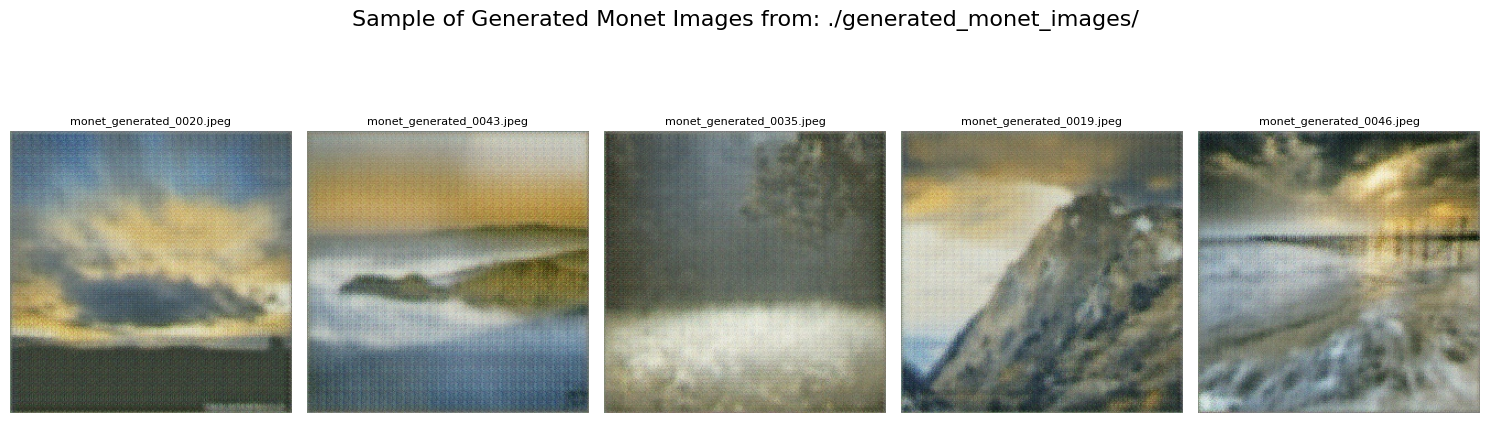

In [ ]:


# Define the directory where generated images are saved
GENERATED_IMAGES_DIR = './generated_monet_images/'

def display_images_from_folder(folder_path, num_images=5):
    """
    Loads and displays a specified number of images from a given folder.
    """
    image_files = glob.glob(os.path.join(folder_path, '*.jpeg'))
    
    if not image_files:
        print(f"No JPEG images found in: {folder_path}")
        return

    # Shuffle to get a random sample each time, if you have more than num_images
    np.random.shuffle(image_files)
    
    # Take only the number of images requested, or all if less than requested
    display_files = image_files[:num_images]

    plt.figure(figsize=(15, 5)) # Adjust figure size as needed
    plt.suptitle(f"Sample of Generated Monet Images from: {folder_path}", fontsize=16)

    for i, img_path in enumerate(display_files):
        try:
            img = Image.open(img_path)
            plt.subplot(1, num_images, i + 1)
            plt.imshow(img)
            plt.title(os.path.basename(img_path), fontsize=8)
            plt.axis('off')
        except Exception as e:
            print(f"Could not load image {img_path}: {e}")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
    plt.show()

# Call the function to display images
display_images_from_folder(GENERATED_IMAGES_DIR, num_images=5)



Since the model was trained on a very small dataset for a short time, expect these images to be of low quality, possibly just noise or very crude approximations of style.